# **Chapter 10**
## *Building Univariate Time Series Models Using Statistical Methods*,

This chapter kick offs the journey into modeling and forecasting time series. The chapter intuitively explains what autocorrelation function (ACF) and partial autocorrelation function (PACF) plots are and how they are used, and then moves in to training, diagnosing, and comparing different models, including exponential smoothing, autoregressive integrated moving average (ARIMA), and seasonal ARIMA (SARIMA). Additionally, this chapter introduces grid search and hyperparameter tuning.

In this chapter, we will cover the following recipes:
* Plotting ACF and PACF
* Forecasting univariate time series data with exponential smoothing
* Forecasting univariate time series data with non-seasonal ARIMA
* Forecasting univariate time series data with seasonal ARIMA

Before diving into these recipes, pay special attention to the upcoming Technical requirements section, in which you will perform upfront preparation. This will remove any distractions and repetitive coding so that you can focus on the recipe's core goals and the concepts behind each implementation.

# ---START: Technical Requirements---


In [2]:
# in colab statsmodels is version 0.10.2
# you will need to run the following to update it to 0.13.2
# the recipe uses 0.13.2

#!pip install statsmodels -U

In [3]:
import statsmodels
statsmodels.__version__

'0.13.5'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.api import (kpss, adfuller,
                                 seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm
from pathlib import Path


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

In [5]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
#plt.rcParams['figure.dpi'] = 100          ## use 300 for printing
plt.rc('font', size=8)                     ##
plt.rc('axes', titlesize=14)               ##
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ##
#############################################

**Check core library versions used in the recipe**
* if using **Colab** ensure the versions are the same. If needed to update use
```shell
!pip install <library_name> -U
```

In [6]:
import matplotlib
import scipy
import sklearn


print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}
numpy -> {np.__version__}
scipy -> {scipy.__version__}
statsmodels -> {sm.__version__}
sklearn -> {sklearn.__version__}
''')




Matplotlib -> 3.7.1
pandas -> 1.5.3
numpy -> 1.22.4
scipy -> 1.10.1
statsmodels -> 0.13.5
sklearn -> 1.2.2



In [7]:
life_file = Path('/content/drive/MyDrive/Lectura Técnica/Time-Series-Analysis-with-Python-Cookbook/datasets/Ch10/life_expectancy_birth.csv')
milk_file = Path('/content/drive/MyDrive/Lectura Técnica/Time-Series-Analysis-with-Python-Cookbook/datasets/Ch10/milk_production.csv')

life = pd.read_csv(life_file,
                   index_col='year',
                   parse_dates=True,
                   skipfooter=1)

milk = pd.read_csv(milk_file,
                   index_col='month',
                   parse_dates=True)

In [8]:
life.shape

(59, 1)

In [9]:
milk.shape

(168, 1)

<Axes: title={'center': 'Monthly Milk Production'}, xlabel='month'>

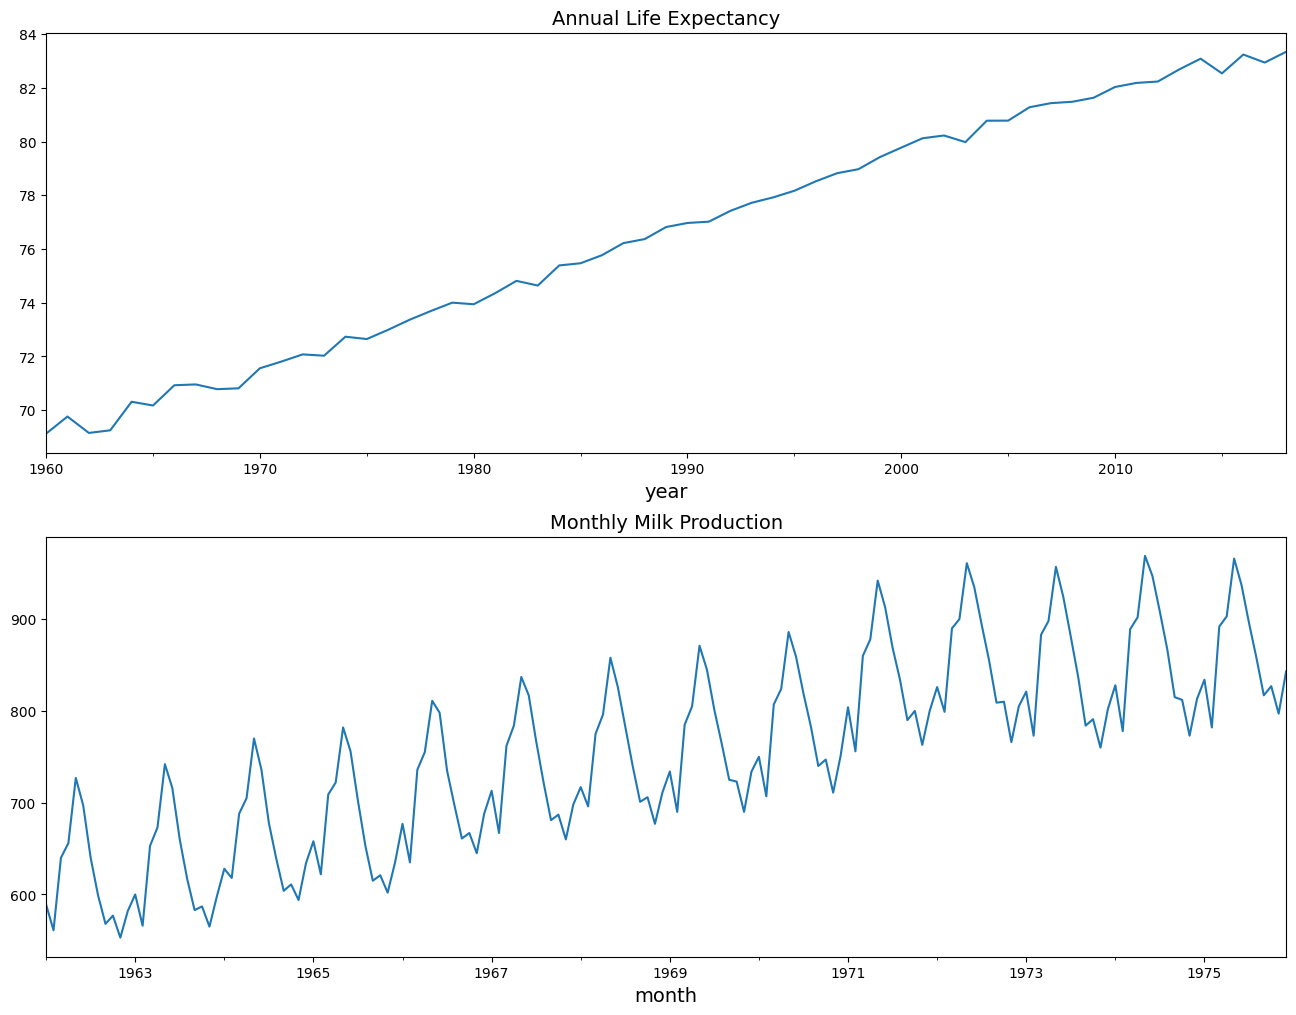

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
life.plot(title='Annual Life Expectancy', legend=False, ax=ax[0])
milk.plot(title='Monthly Milk Production', legend=False, ax=ax[1])


# plt.savefig('images/fig_10.1.png', bbox_inches='tight', dpi=300)

In [11]:
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [12]:
test_split = 0.15
milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)

train: 143 , test: 25
train: 50 , test: 9


In [13]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [14]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [15]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    # plt.show()
    return ax

In [16]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]
    return combo

# Recipe 1. Plotting ACF and PACF

<Axes: xlabel='year'>

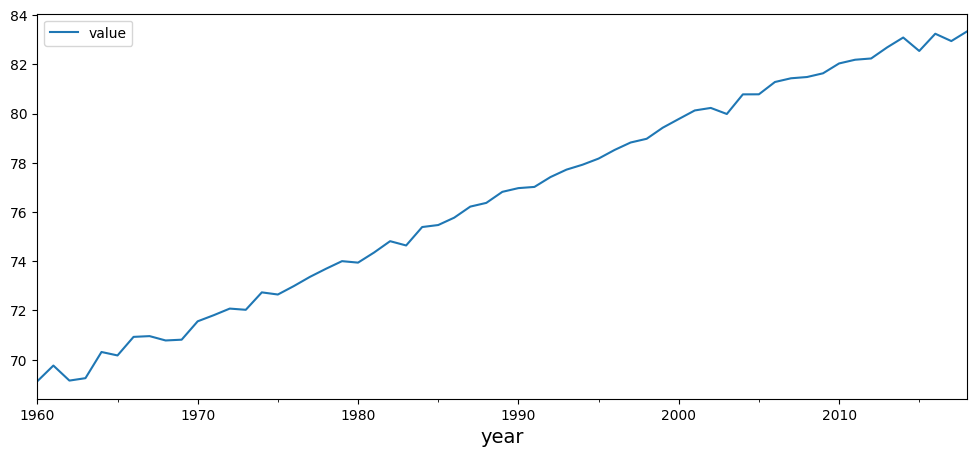

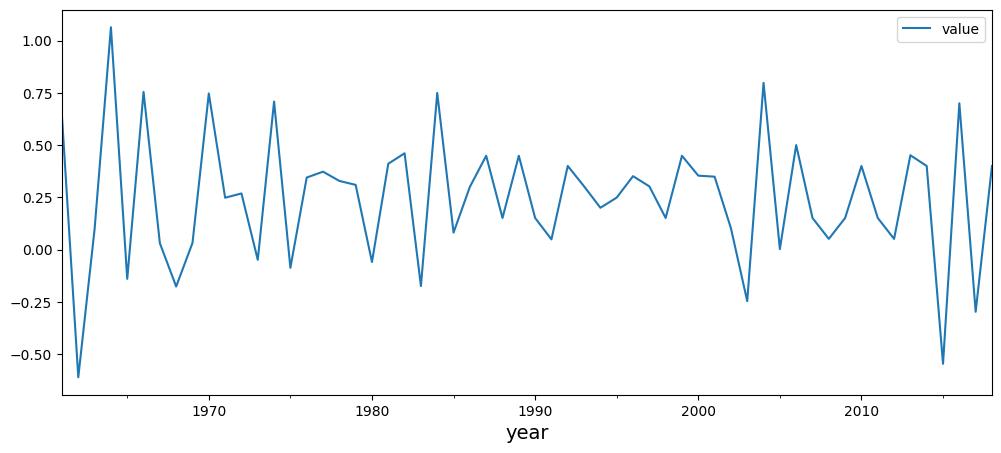

In [17]:
# plt.rcParams["figure.figsize"] = [16, 4]
life.plot()
life_diff = life.diff().dropna()
life_diff.plot()

In [18]:
check_stationarity(life_diff)

'Stationary	 p-value:1.556218967600307e-14 	 lags:1


('Stationary', 1.556218967600307e-14)

## ACF - PACF
### Interpretación para AR - MA - ARMA
https://spureconomics.com/interpreting-acf-and-pacf-plots/

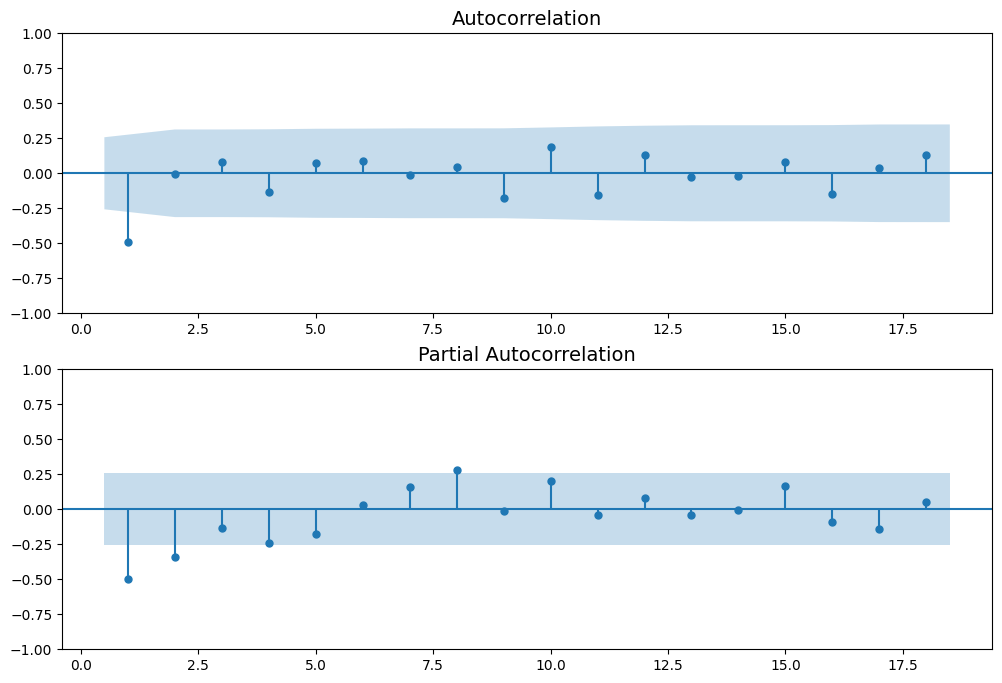

In [19]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1])
#plt.savefig('images/fig_10.2.png', bbox_inches='tight', dpi=300)
plt.show()

<Axes: xlabel='month'>

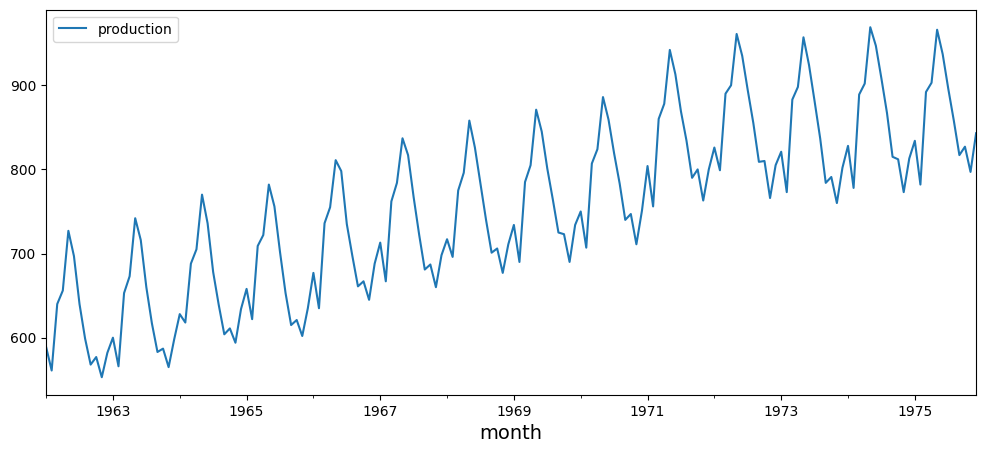

In [20]:
milk.plot()

In [21]:
milk_diff_12 = milk.diff(12).dropna()

In [22]:
check_stationarity(milk_diff_12)

'Non-Stationary	 p-value:0.1607988052771125 	 lags:12


('Non-Stationary', 0.1607988052771125)

In [23]:
milk_diff_12_1 = milk.diff(12).diff(1).dropna()
check_stationarity(milk_diff_12_1)

'Stationary	 p-value:1.865423431878848e-05 	 lags:11


('Stationary', 1.865423431878848e-05)

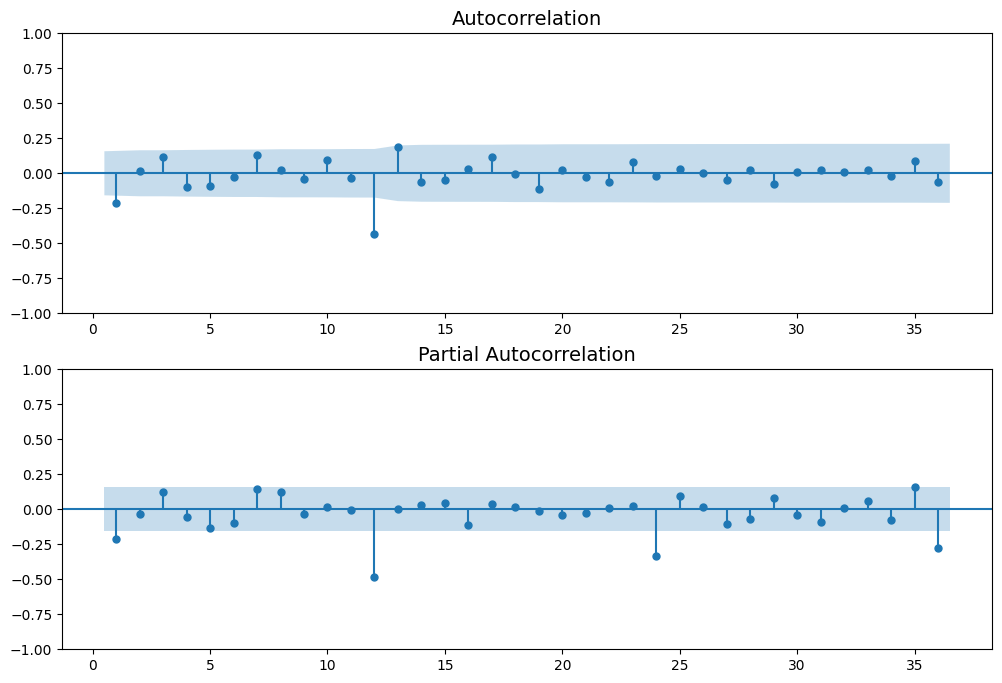

In [24]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36)
# plt.savefig('images/fig_10.3.png', bbox_inches='tight', dpi=300)
plt.show()

## There is more

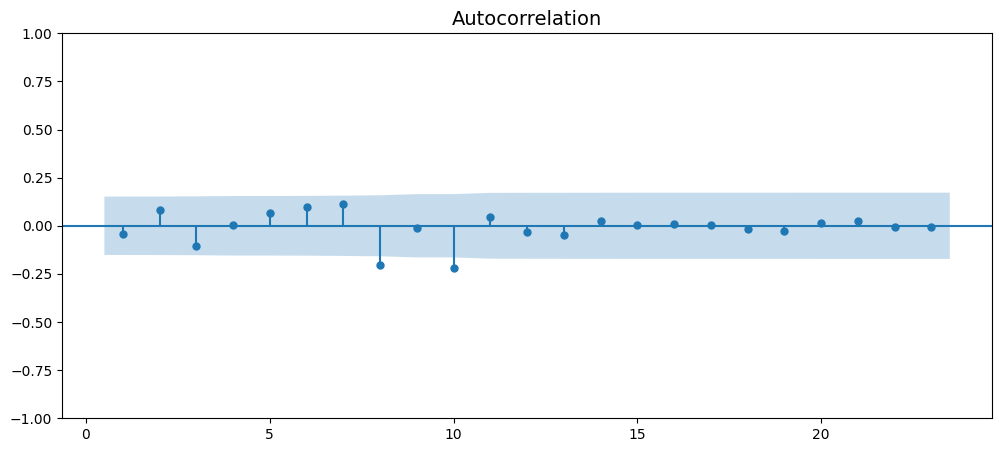

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(milk, order=(0,1,1),
                seasonal_order=(0,1,1, 12)).fit(disp=False)
plot_acf(model.resid[1:], zero=False)
#plt.savefig('images/fig_10.4.png', bbox_inches='tight', dpi=300)
plt.show()

<Axes: xlabel='month'>

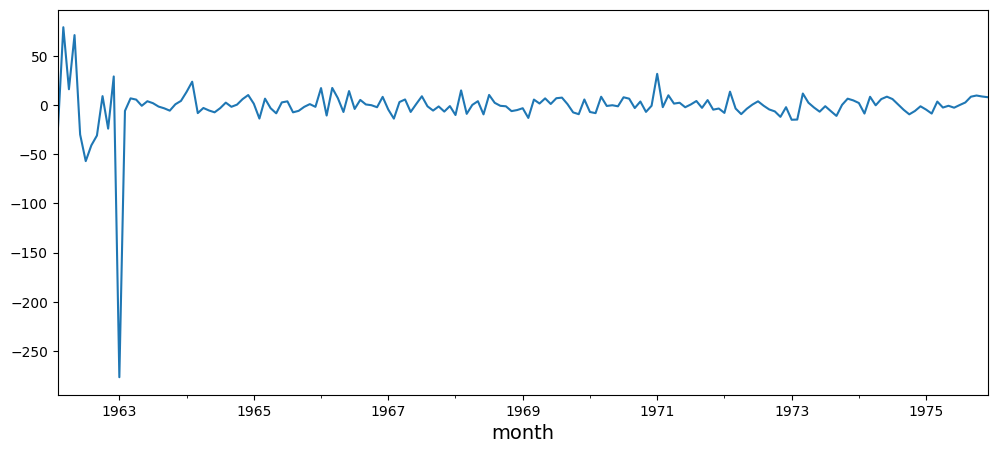

In [26]:
model.resid[1:].plot()

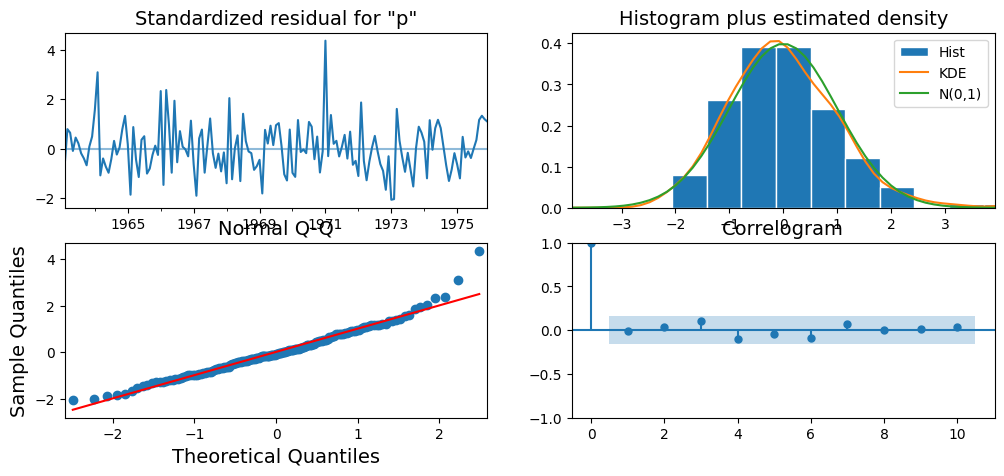

In [27]:
model.plot_diagnostics();

In [28]:
model.resid[1:]

month
1962-02-01   -27.995259
1962-03-01    78.999549
1962-04-01    16.001272
1962-05-01    71.000258
1962-06-01   -29.998857
                ...    
1975-08-01     2.556263
1975-09-01     8.435671
1975-10-01     9.640233
1975-11-01     8.624987
1975-12-01     7.918949
Length: 167, dtype: float64

# Recipe 2. Forecasting Univariate Time Series Data with Exponential Smoothing

In [29]:
from statsmodels.tsa.api import ExponentialSmoothing

In [30]:
trend = ['add', 'mul']
damped = [True, False]
life_ex_comb = combinator([trend, damped])
life_ex_comb

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [31]:
train = life_train.values.ravel()
y = life_test.values.ravel()
score = {}
for i, (t, dp) in enumerate(life_ex_comb):
    exp = ExponentialSmoothing(train,
                     trend=t,
                     damped_trend=dp,
                     seasonal=None)
    model = exp.fit(use_brute=True, optimized=True)
    y_hat = model.forecast(len(y))
    score[i] = {'trend':t,
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic,
                'AICc':model.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

In [32]:
life_best_model = get_best_model(score, 'AIC')

Best model: 1 with lowest AIC score: -137.03060180016485


In [33]:
life_best_model.summary()

Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Thu, 29 Jun 2023"
Box-Cox:,False,Time:,13:12:28
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621951,alpha,True
smoothing_trend,0.1621951,beta,True


In [34]:
life_best_model.params_formatted

,name,param,optimized
smoothing_level,alpha,0.162195,True
smoothing_trend,beta,0.162195,True
initial_level,l.0,68.748480,True
initial_trend,b.0,0.242227,True


<Axes: xlabel='year'>

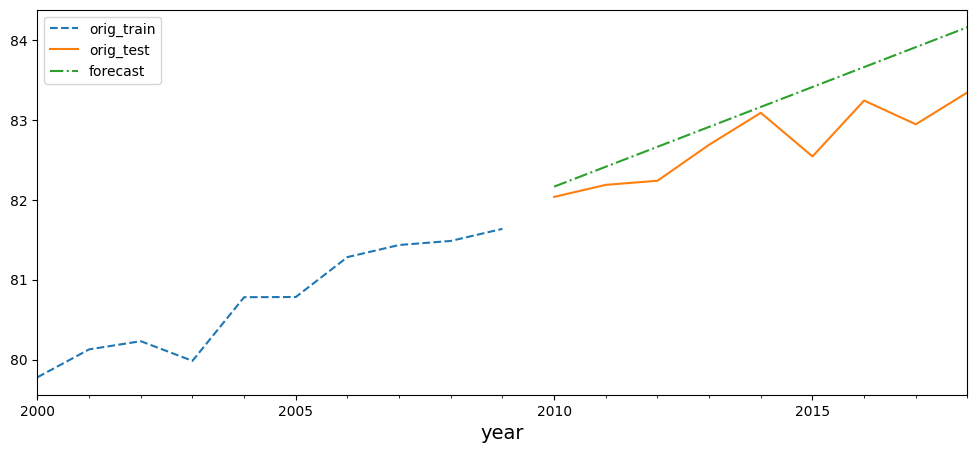

In [35]:
plot_forecast(life_best_model, '2000', life_train, life_test)
#plt.savefig('images/fig_10.6.png', bbox_inches='tight', dpi=300)

In [36]:
#plt.savefig('images/fig_10.6.png', bbox_inches='tight', dpi=300)

In [37]:
trend , damped= ['add', 'mul'], [True, False]
seasonal, periods = ['add' , 'mul'], [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal, periods])

In [38]:
len(milk_exp_comb)

24

In [39]:
train = milk_train.values.ravel()
y = milk_test.values.ravel()
milk_model_scores = {}
for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    exp = ExponentialSmoothing(train,
                        trend=t,
                        damped_trend=dp,
                        seasonal=s,
                        seasonal_periods=sp)
    model = exp.fit(use_brute=True, optimized=True)
    y_hat = model.forecast(len(y))
    milk_model_scores[i] = {'trend':t,
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic,
                'AICc': model.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

In [40]:
milk_model = get_best_model(milk_model_scores)

Best model: 8 with lowest AIC score: 593.7138896839506


In [41]:
milk_model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Thu, 29 Jun 2023"
Box-Cox:,False,Time:,13:12:33
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859243,alpha,True
smoothing_trend,6.5801e-08,beta,True


<Axes: xlabel='month'>

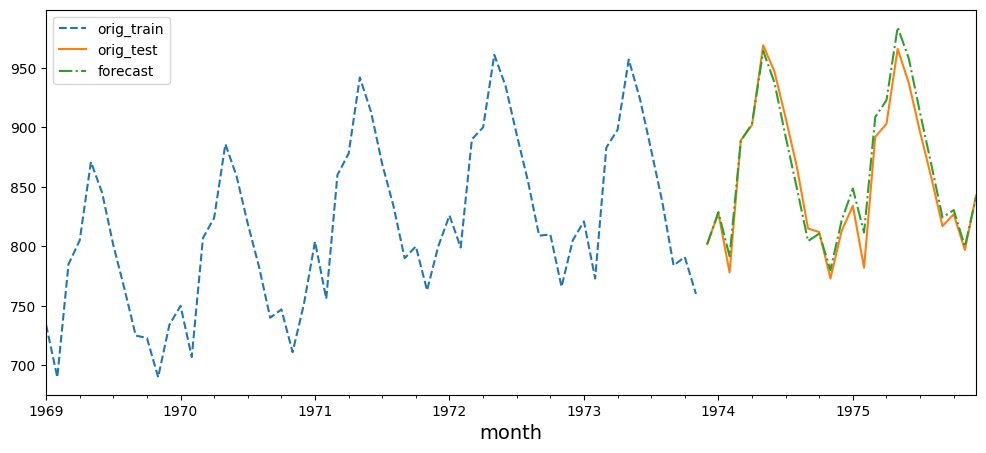

In [42]:
plot_forecast(milk_model, '1969', milk_train, milk_test)
# plt.savefig('images/fig_10.8.png', bbox_inches='tight', dpi=300)

## There is more

In [43]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 70.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 17.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build 

In [44]:
from darts.models import ExponentialSmoothing
from darts import TimeSeries

In [45]:
import darts
darts.__version__

'0.24.0'

In [46]:
model = ExponentialSmoothing(seasonal_periods=12)
ts = TimeSeries.from_dataframe(milk.reset_index(),
                                    time_col='month', value_cols='production', freq='MS')
train, test = split_data(ts, 0.15)

train: 143 , test: 25


In [47]:
model.fit(train)
forecast = model.predict(len(test), num_samples=100)

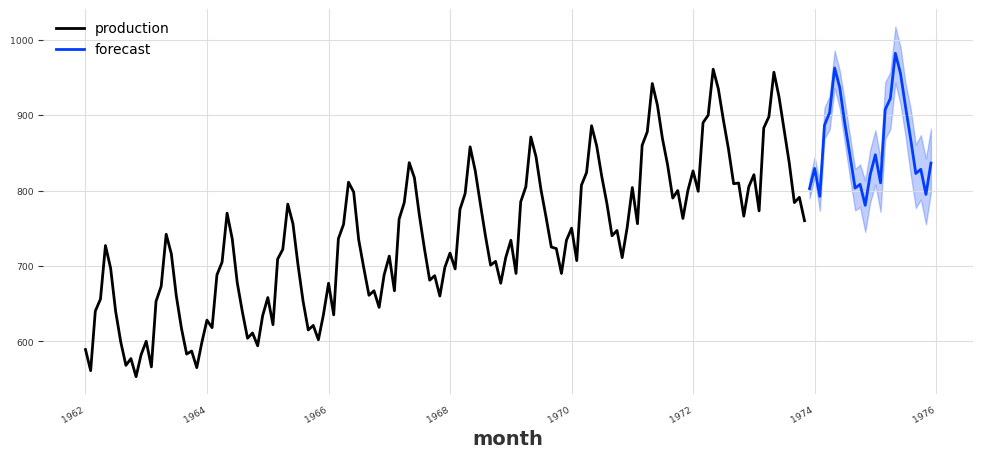

In [48]:
train.plot()
forecast.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
# plt.savefig('images/fig_10.9.png', bbox_inches='tight', dpi=300)

In [49]:
model.model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Thu, 29 Jun 2023"
Box-Cox:,False,Time:,13:13:44
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859243,alpha,True
smoothing_trend,6.5801e-08,beta,True


# Recipe 3. Forecasting Univariate Time Series Data with Non-Seasonal ARIMA

In [50]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
plt.rcParams["figure.figsize"] = [14, 4]

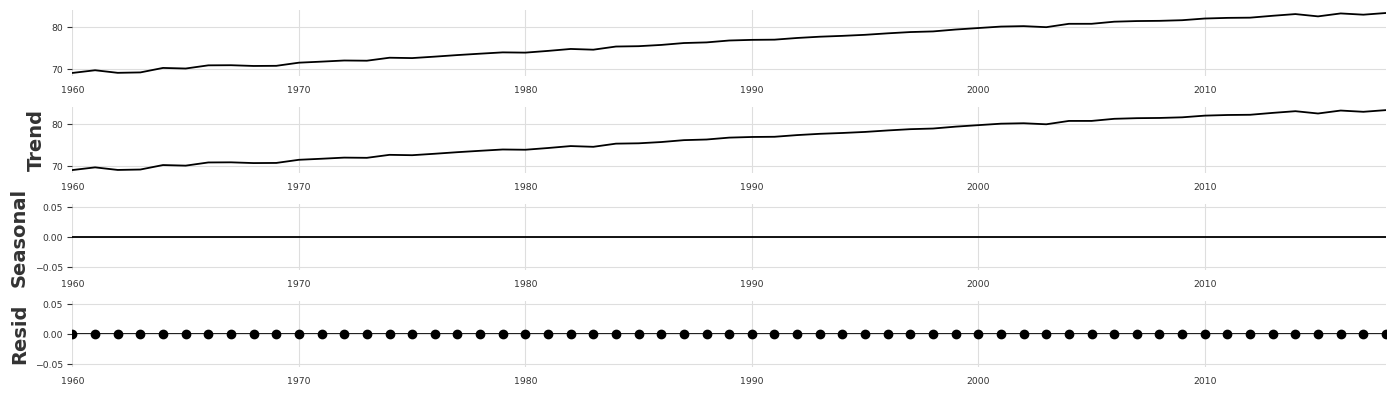

In [51]:
decomposed = seasonal_decompose(life)
decomposed.plot()
#plt.savefig('images/fig_10.10.png', bbox_inches='tight', dpi=300)
plt.show()

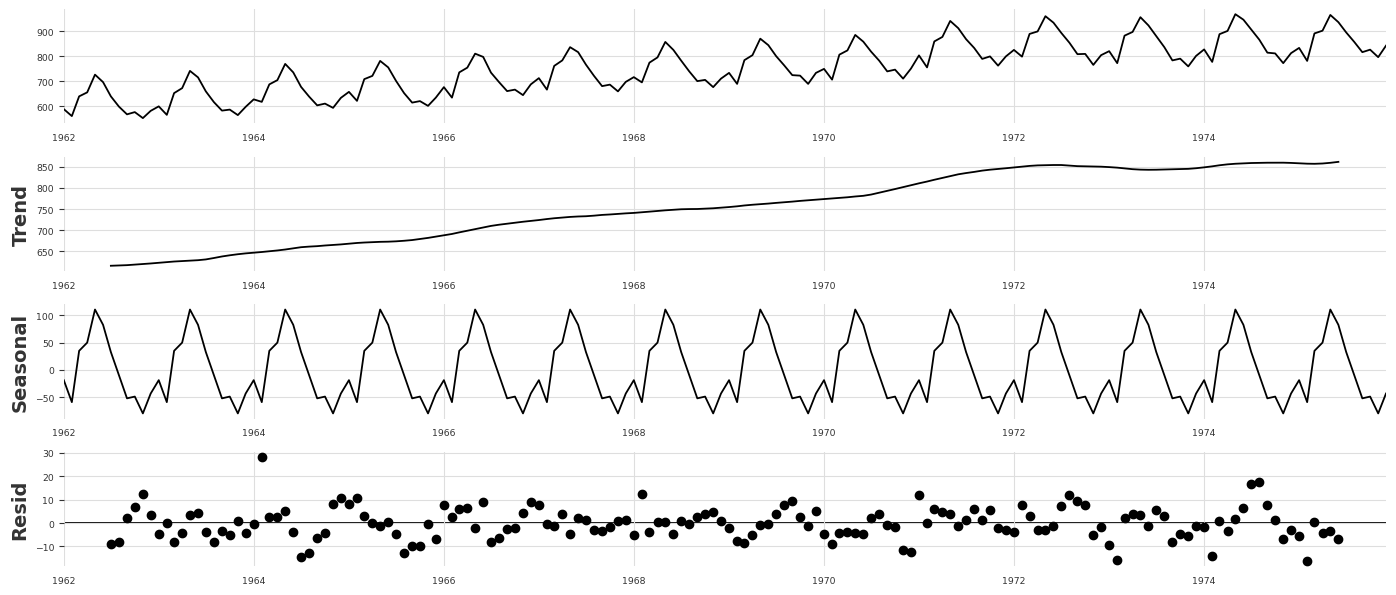

In [52]:
plt.rcParams["figure.figsize"] = [14, 6]
decomposed = seasonal_decompose(milk, period=12)
decomposed.plot(); plt.show()

In [53]:
from pandas.plotting import autocorrelation_plot

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

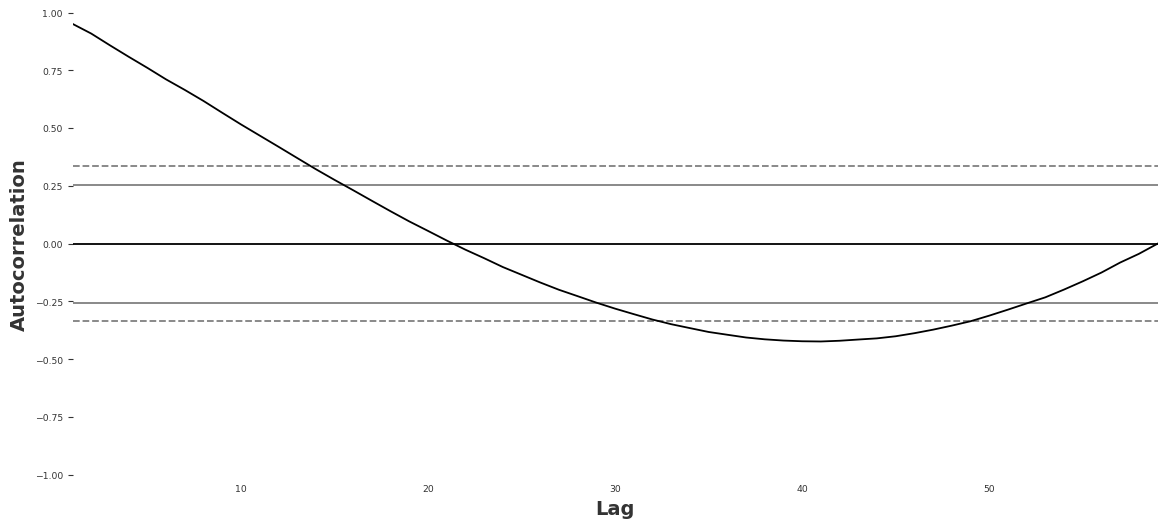

In [54]:
autocorrelation_plot(life)

In [55]:
check_stationarity(life)

'Non-Stationary	 p-value:0.6420882853800043 	 lags:2


('Non-Stationary', 0.6420882853800043)

In [56]:
life_df1 = life.diff().dropna()
check_stationarity(life_df1)

'Stationary	 p-value:1.556218967600307e-14 	 lags:1


('Stationary', 1.556218967600307e-14)

<Axes: xlabel='year'>

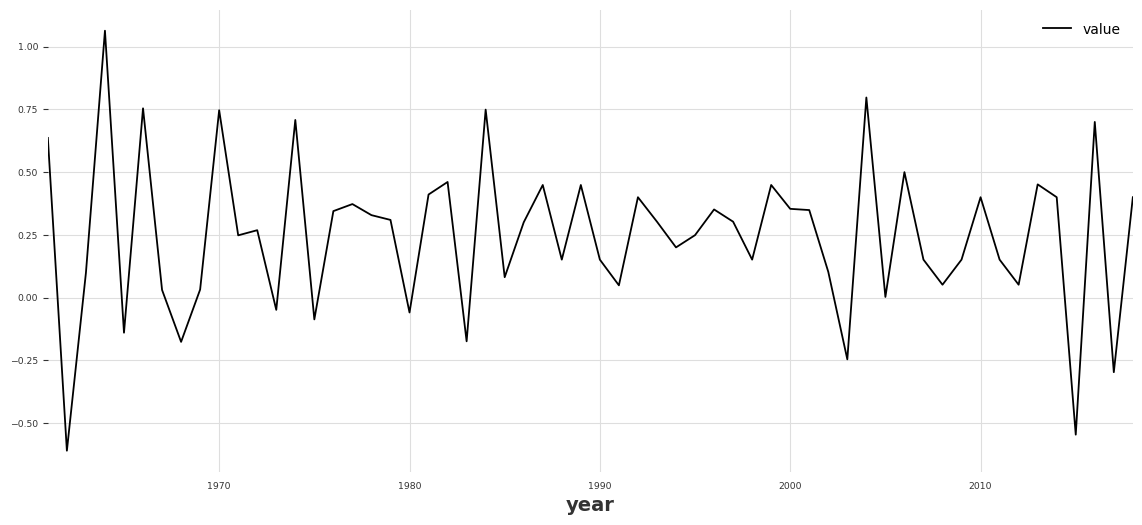

In [57]:
life_df1.plot()
#plt.savefig('images/fig_10.11.png', bbox_inches='tight', dpi=300)

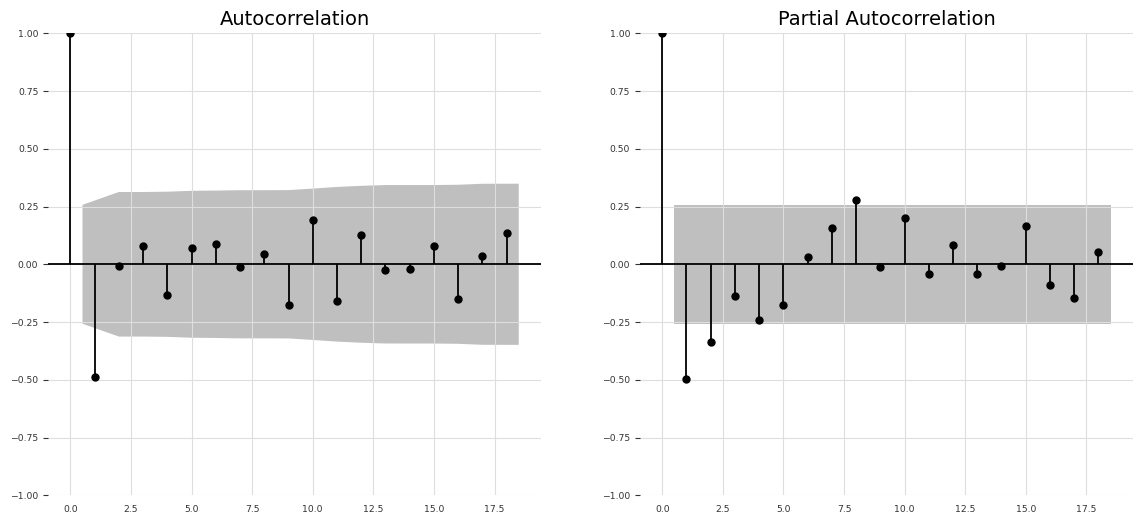

In [58]:
fig, ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1])
#plt.savefig('images/fig_10.12.png', bbox_inches='tight', dpi=300)
plt.show()

In [59]:
model = ARIMA(life_train, order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -24.161
Date:                Thu, 29 Jun 2023   AIC                             52.321
Time:                        13:13:50   BIC                             56.105
Sample:                    01-01-1960   HQIC                            53.757
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0827      0.200      0.413      0.680      -0.310       0.475
sigma2         0.1569      0.032      4.918      0.000       0.094       0.219
===================================================================================
Ljung-Box (L1) (Q):                  12.54   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               0.43   Skew:                             0.07
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [60]:
(acorr_ljungbox(life_df1,
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()
# there is autocorrelation as we would expect

24

In [61]:
(acorr_ljungbox(results.resid,
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

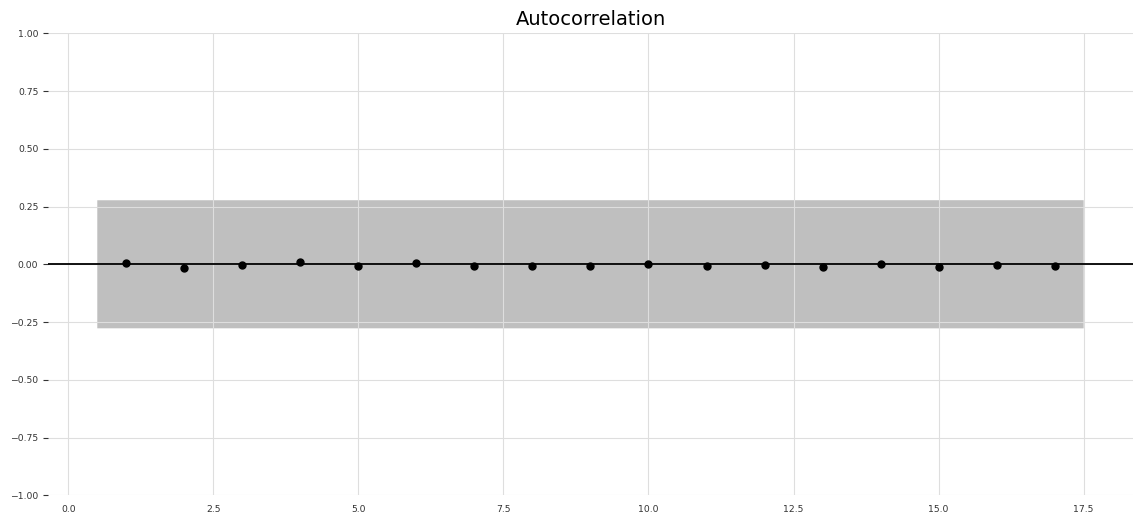

In [62]:
plot_acf(results.resid, zero=False);plt.show()

In [63]:
# from statsmodels.graphics.gofplots import qqplot

# pd.Series(results.resid).plot(kind='kde');plt.show()
# qqplot(results.resid, line='s'); plt.show()

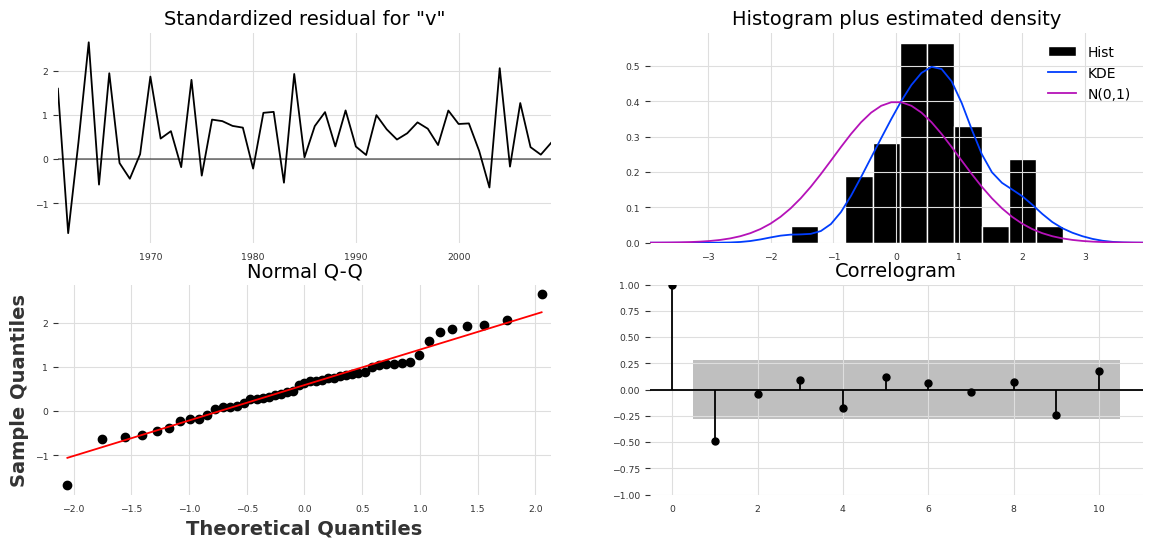

In [64]:
results.plot_diagnostics()
#plt.savefig('images/fig_10.15.png', bbox_inches='tight', dpi=300)
plt.show()

In [65]:
(acorr_ljungbox(results.resid,
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

In [66]:
from scipy.stats import shapiro
shapiro(results.resid)[1] < 0.05

True

<Axes: xlabel='year'>

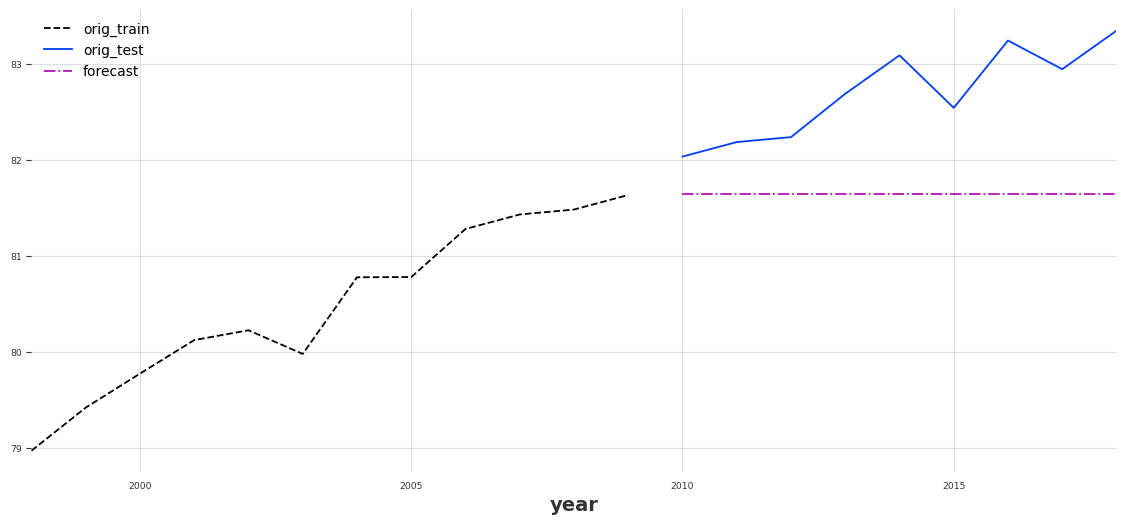

In [67]:
plot_forecast(results, '1998', life_train, life_test)

## There is more

In [68]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_test.values.ravel()
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic,
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

In [69]:
get_best_model(score, 'AIC')

Best model: 8 with lowest AIC score: 7.698946116481412


In [70]:
best_m = get_best_model(score, 'AIC')

Best model: 8 with lowest AIC score: 7.698946116481412


In [71]:
score[8]

{'order': (0, 2, 2),
 'AIC': 7.698946116481412,
 'BIC': 13.312549149205086,
 'AICc': 8.244400661935959,
 'RMSPE': 0.055948714935375884,
 'RMSE': 0.46351850695592445,
 'MAPE': 0.004493470419427183,
 'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x7f7759e087c0>}

In [72]:
score[4]['model'].model_orders

{'trend': 0,
 'exog': 0,
 'ar': 0,
 'ma': 1,
 'seasonal_ar': 0,
 'seasonal_ma': 0,
 'reduced_ar': 0,
 'reduced_ma': 1,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [73]:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index()

,index,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
0,8,"(0, 2, 2)",7.698946,13.312549,8.244401,0.055949,0.463519,0.004493,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",9.533197,17.100478,10.442288,0.054759,0.453643,0.004395,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,17,"(1, 2, 2)",9.677102,17.161906,10.607334,0.055717,0.461601,0.004468,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,23,"(2, 1, 2)",11.509873,20.968975,12.905222,0.054476,0.451296,0.004365,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,26,"(2, 2, 2)",13.833852,23.189857,15.262423,0.074461,0.617242,0.006221,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,25,"(2, 2, 1)",19.672789,27.157593,20.603021,0.054426,0.451322,0.003985,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,16,"(1, 2, 1)",23.19374,28.807343,23.739194,0.048496,0.402102,0.003585,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,22,"(2, 1, 1)",25.29768,32.864961,26.206771,0.046764,0.387718,0.003497,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,7,"(0, 2, 1)",31.316646,35.059048,31.583313,0.047356,0.392639,0.003599,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,13,"(1, 1, 1)",33.425771,39.101232,33.959104,0.043427,0.360003,0.003382,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [74]:
pd.DataFrame(score).T.sort_values(by='BIC').reset_index()

,index,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
0,8,"(0, 2, 2)",7.698946,13.312549,8.244401,0.055949,0.463519,0.004493,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",9.533197,17.100478,10.442288,0.054759,0.453643,0.004395,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,17,"(1, 2, 2)",9.677102,17.161906,10.607334,0.055717,0.461601,0.004468,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,23,"(2, 1, 2)",11.509873,20.968975,12.905222,0.054476,0.451296,0.004365,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,26,"(2, 2, 2)",13.833852,23.189857,15.262423,0.074461,0.617242,0.006221,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,25,"(2, 2, 1)",19.672789,27.157593,20.603021,0.054426,0.451322,0.003985,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,16,"(1, 2, 1)",23.19374,28.807343,23.739194,0.048496,0.402102,0.003585,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,22,"(2, 1, 1)",25.29768,32.864961,26.206771,0.046764,0.387718,0.003497,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,7,"(0, 2, 1)",31.316646,35.059048,31.583313,0.047356,0.392639,0.003599,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,13,"(1, 1, 1)",33.425771,39.101232,33.959104,0.043427,0.360003,0.003382,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [75]:
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  -0.849
Date:                Thu, 29 Jun 2023   AIC                              7.699
Time:                        13:14:09   BIC                             13.313
Sample:                    01-01-1960   HQIC                             9.820
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9446      3.952     -0.492      0.623      -9.690       5.801
ma.L2          0.9967      4.045      0.246      0.805      -6.931       8.924
sigma2         0.0499      0.204      0.245      0.806      -0.349       0.449
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.58   Prob(JB):                         0.40
Heteroskedasticity (H):               0.38   Skew:                             0.17
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='year'>

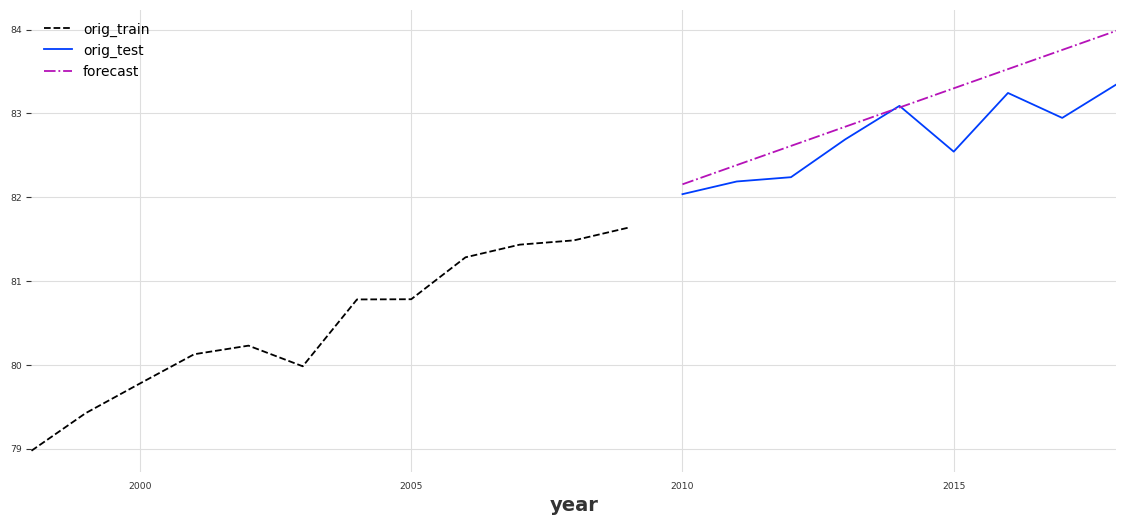

In [76]:
plot_forecast(best_m, '1998', life_train, life_test)

# Recipe 4. Forecasting Univariate Time Series Data with Seasonal ARIMA

In [77]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.rcParams["figure.figsize"] = [14, 4]

<Axes: xlabel='month'>

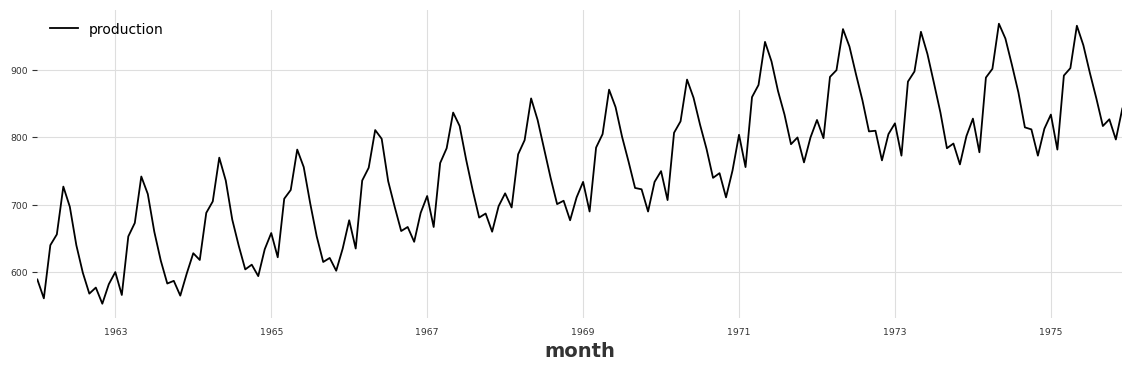

In [78]:
milk.plot()

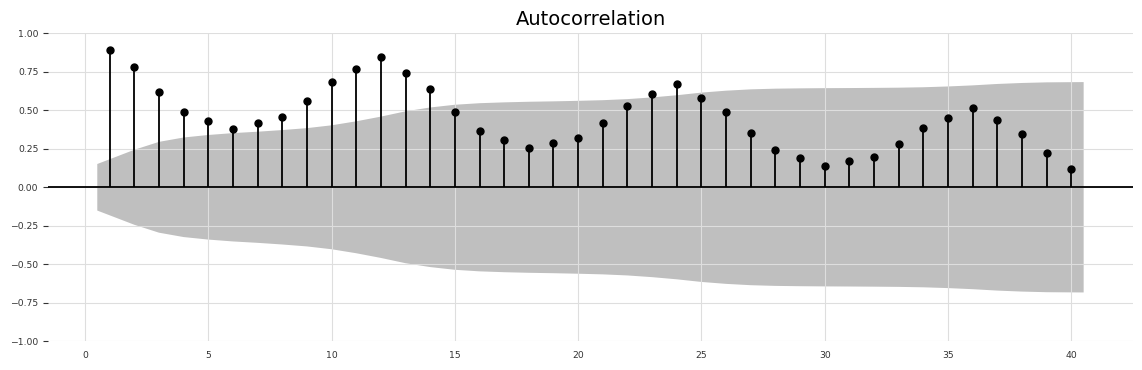

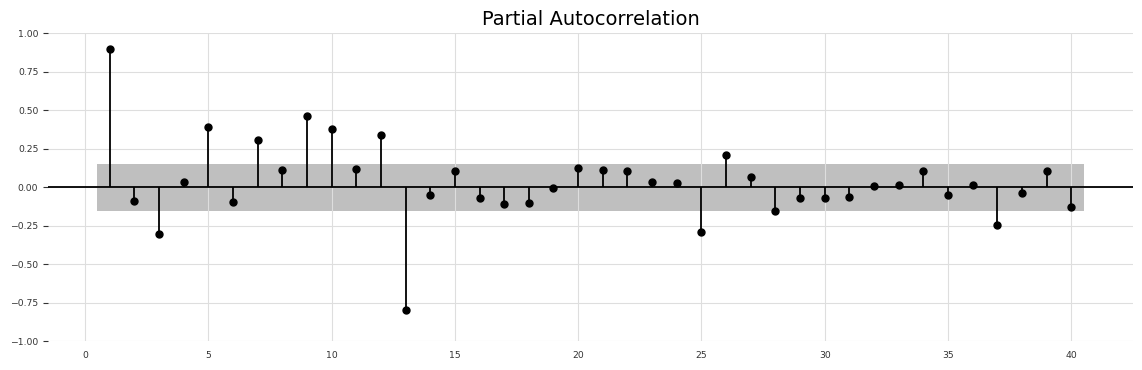

In [79]:
plot_acf(milk, lags=40, zero=False)
plot_pacf(milk, lags=40, zero=False);plt.show()

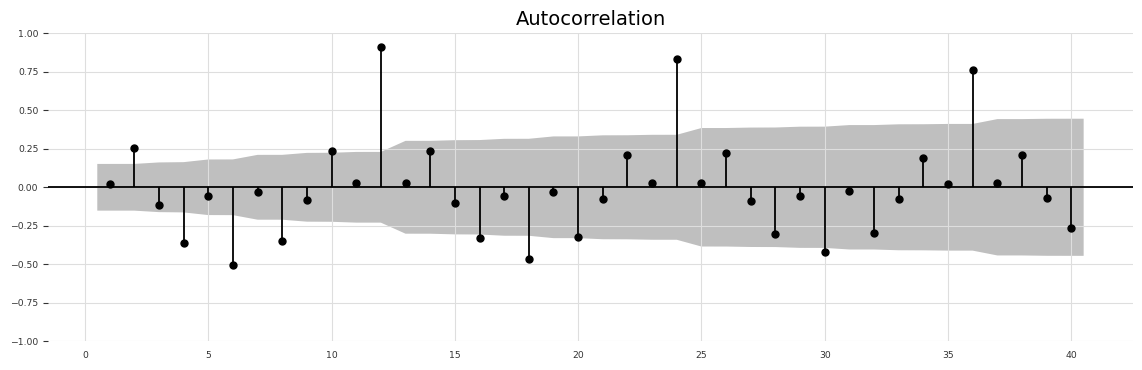

In [80]:
plot_acf(milk.diff(1).dropna(), lags=40, zero=False); plt.show()

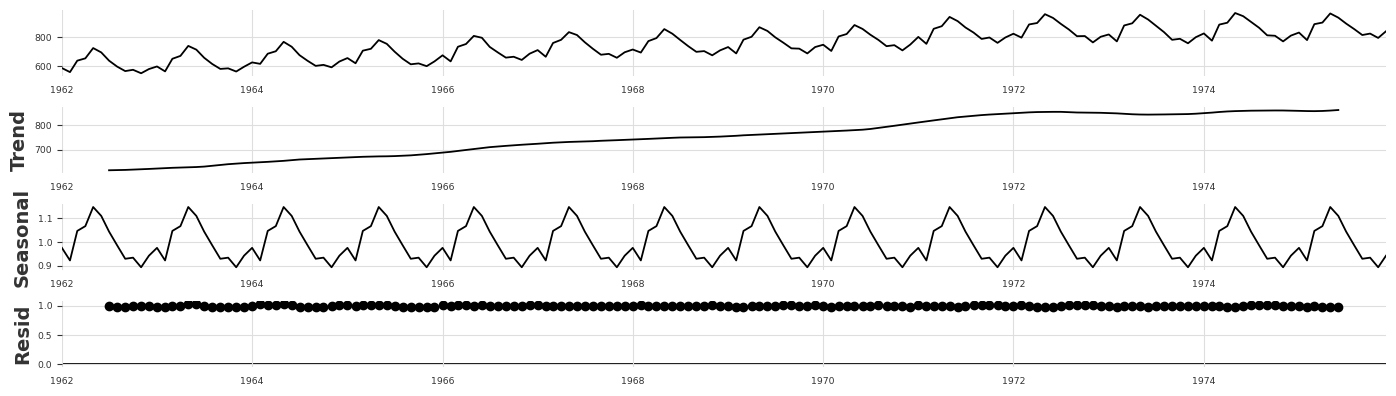

In [81]:
decomposed = seasonal_decompose(milk, period=12, model='multiplicative')
decomposed.plot(); plt.show()

In [82]:
milk_s = decomposed.seasonal

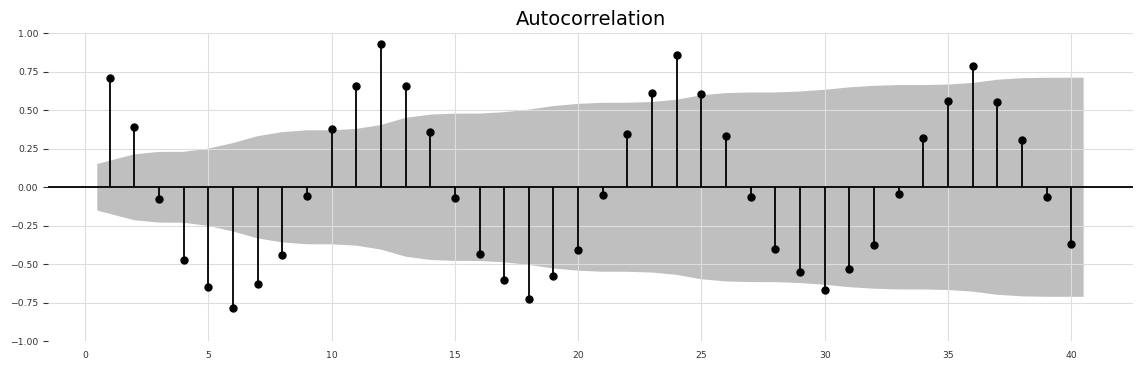

In [83]:
plot_acf(milk_s, zero=False, lags=40);plt.show()

In [84]:
milk_dif_12 = milk.diff(12).dropna()
milk_dif_12_1 = milk.diff(12).diff(1).dropna()

'Non-Stationary	 p-value:0.6274267086030311 	 lags:13
'Non-Stationary	 p-value:0.1607988052771125 	 lags:12
'Stationary	 p-value:1.865423431878848e-05 	 lags:11


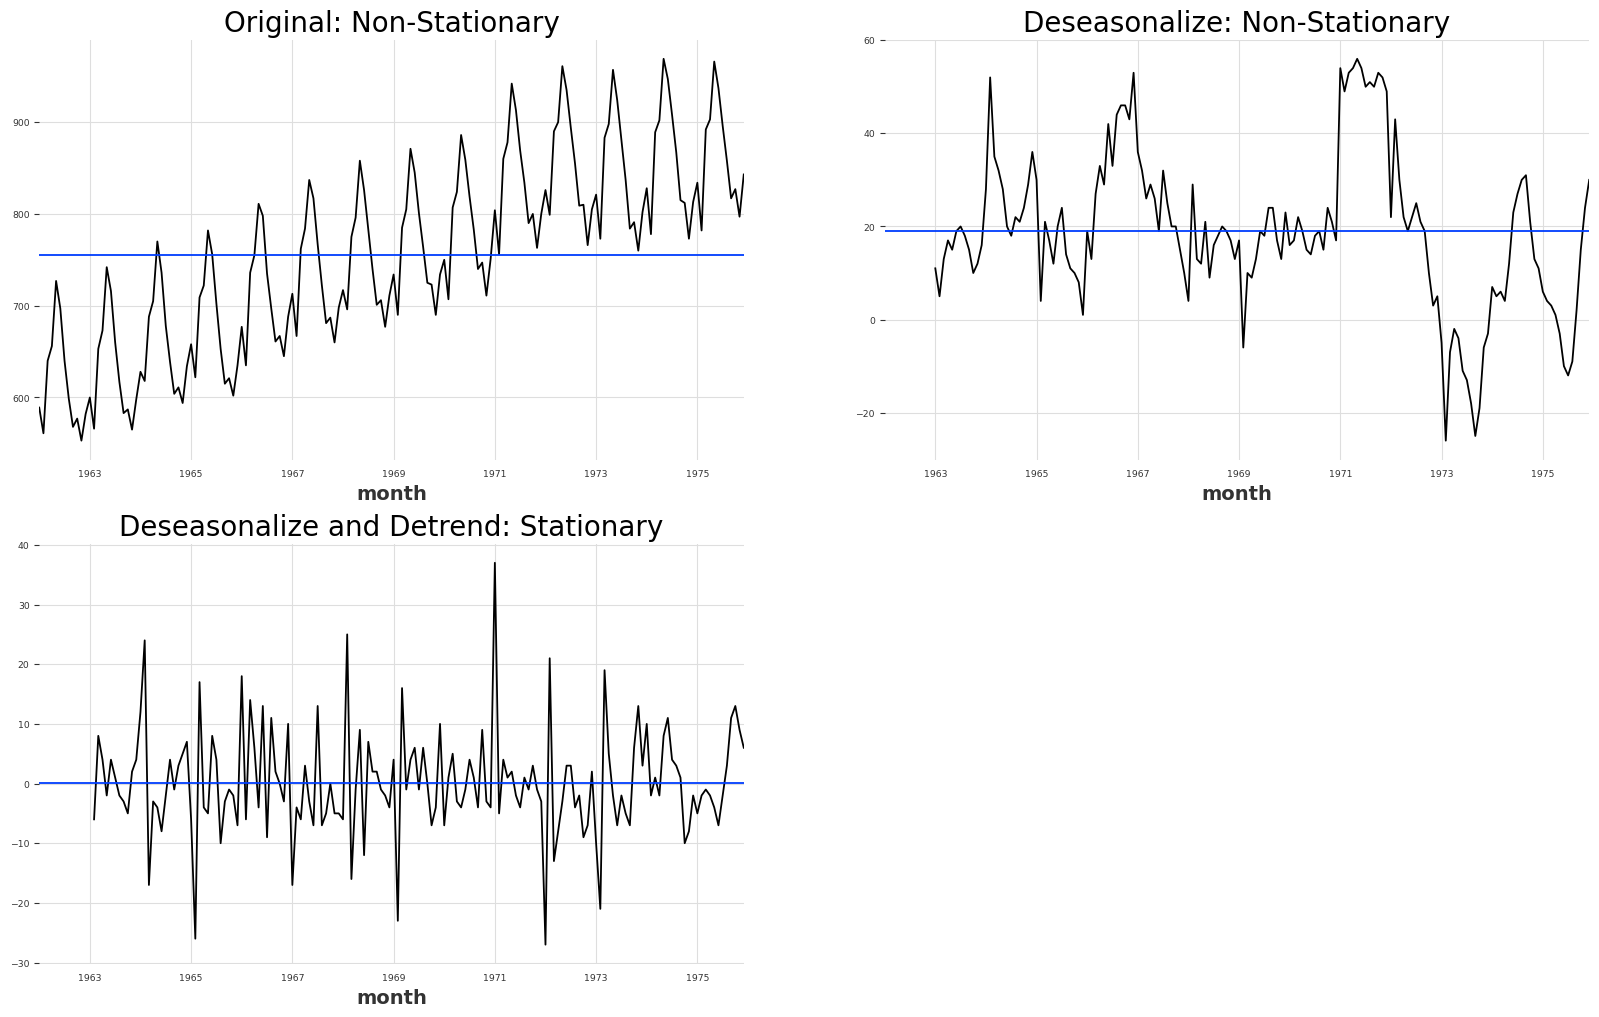

In [85]:
sets = [milk, milk_dif_12, milk_dif_12_1]
desc = ['Original', 'Deseasonalize', 'Deseasonalize and Detrend']
fig, ax = plt.subplots(2,2, figsize=(20,12))
index, l = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    v, r = i // 2, i % 2
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax= ax[v,r], title=f'{d_desc}: {outcome}', legend=False)
    pd.Series(d_set.mean().values.tolist()*l, index=index).plot(ax=ax[v,r])
    ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
# plt.savefig('images/fig_10.21.png', bbox_inches='tight', dpi=300)
plt.show()

### How to Determine AR and MA terms

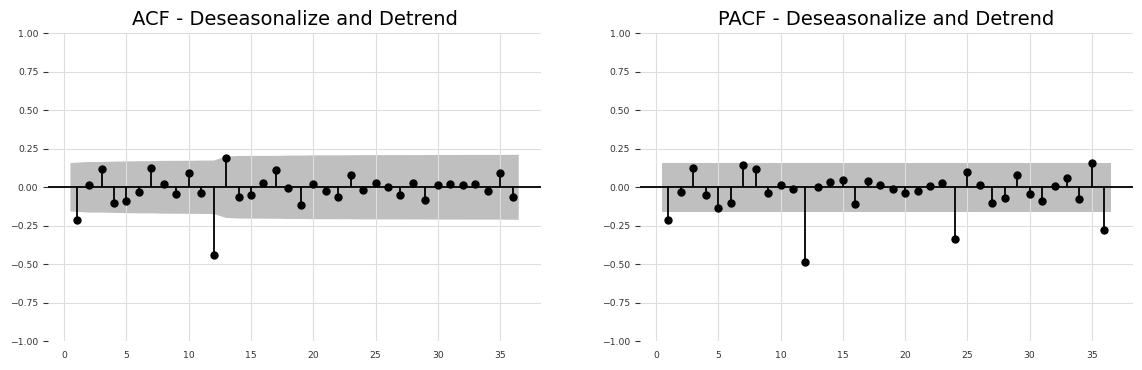

In [86]:
fig, ax = plt.subplots(1,2)
plot_acf(milk_dif_12_1, zero=False, lags=36, ax=ax[0], title=f'ACF - {d_desc}')
plot_pacf(milk_dif_12_1, zero=False, lags=36, ax=ax[1], title=f'PACF - {d_desc}')
plt.show()

[1, 12, 24, 36, 48]


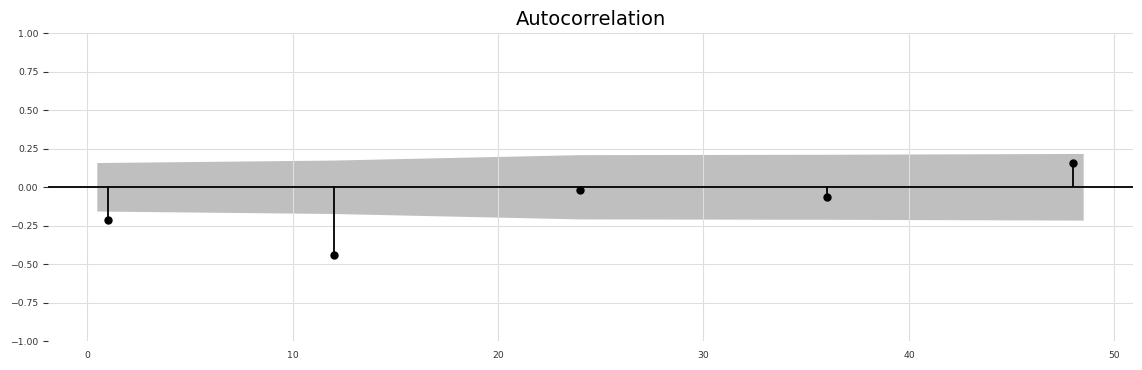

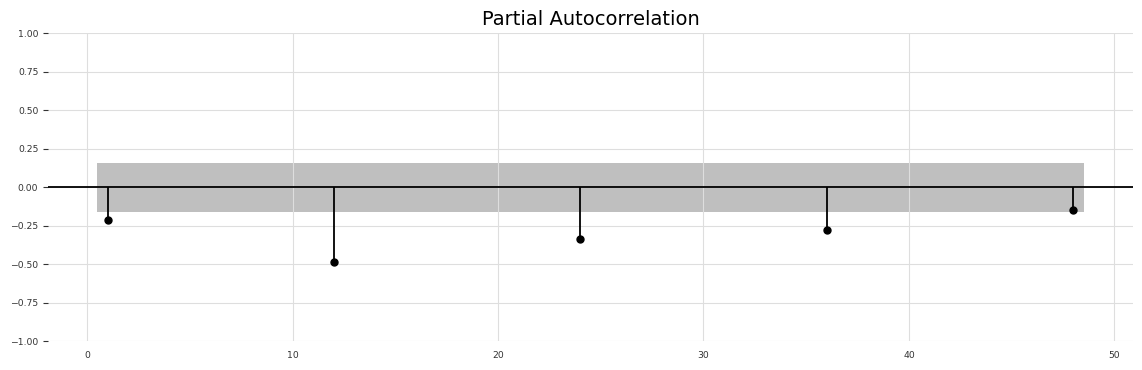

In [87]:
#lags = [1, 12, 24, 36, 48]
lags = [i for i in range(12, 60, 12)]
lags.insert(0, 1)
print(lags)
plot_acf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags)
plot_pacf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags);

### Fitting a SARIMA Model

In [88]:
sarima_model = SARIMAX(milk_train,
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

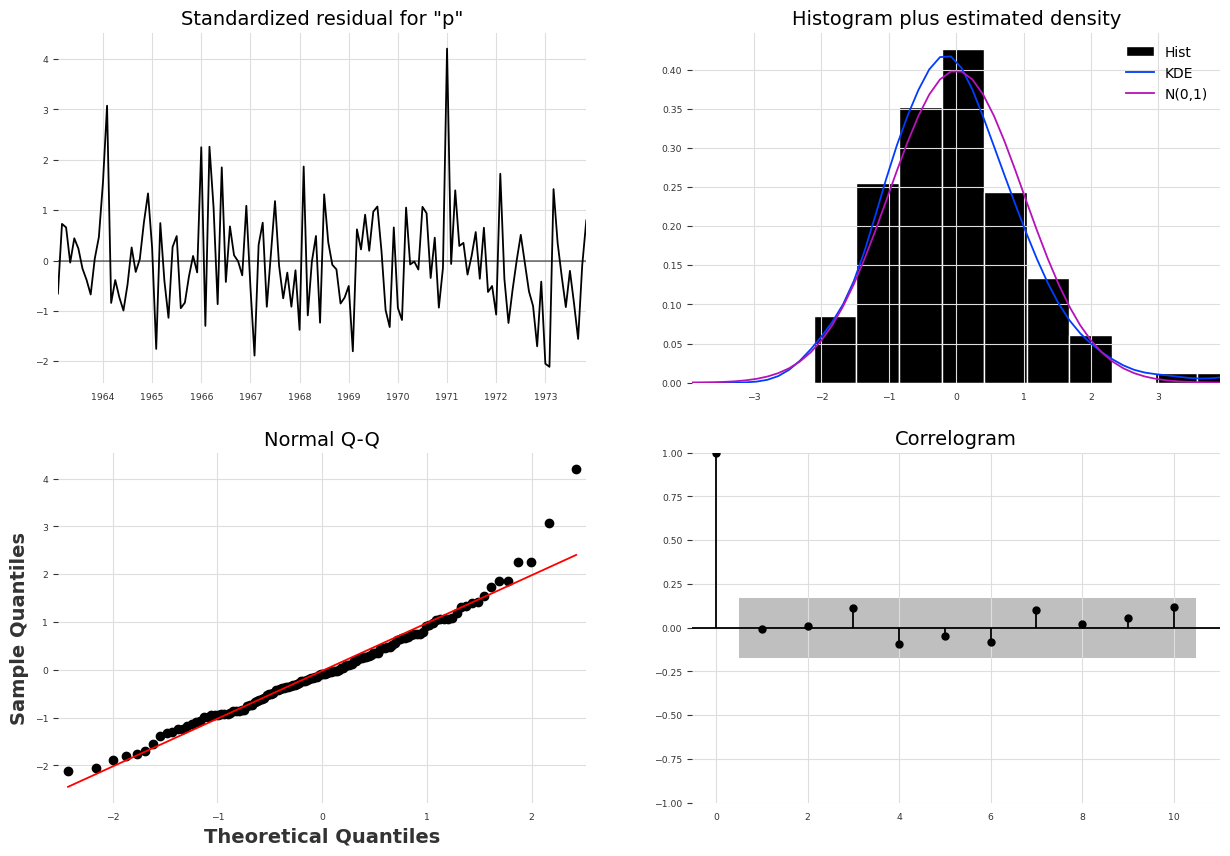

In [89]:
model.plot_diagnostics(figsize=(15,10))
# plt.savefig('images/fig_10.23.png', bbox_inches='tight', dpi=300)
plt.show()

In [90]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         production   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Thu, 29 Jun 2023   AIC                            903.335
Time:                                    13:23:14   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='month'>

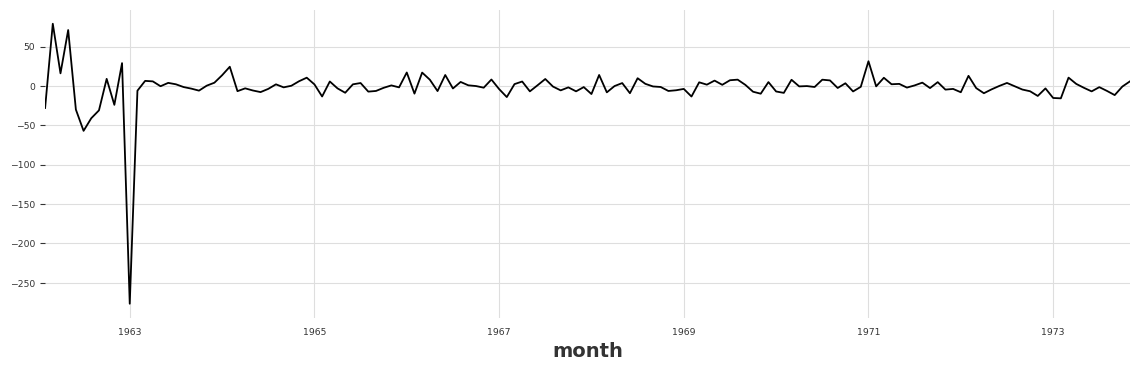

In [91]:
model.resid[1:].plot()

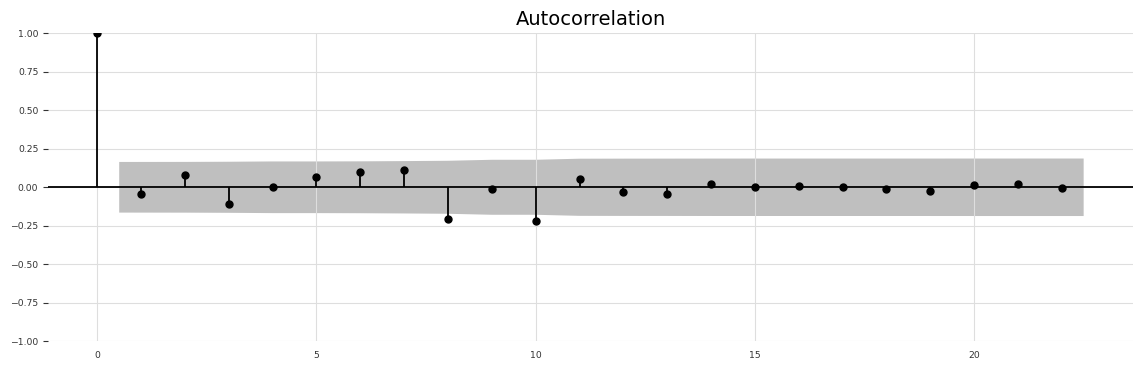

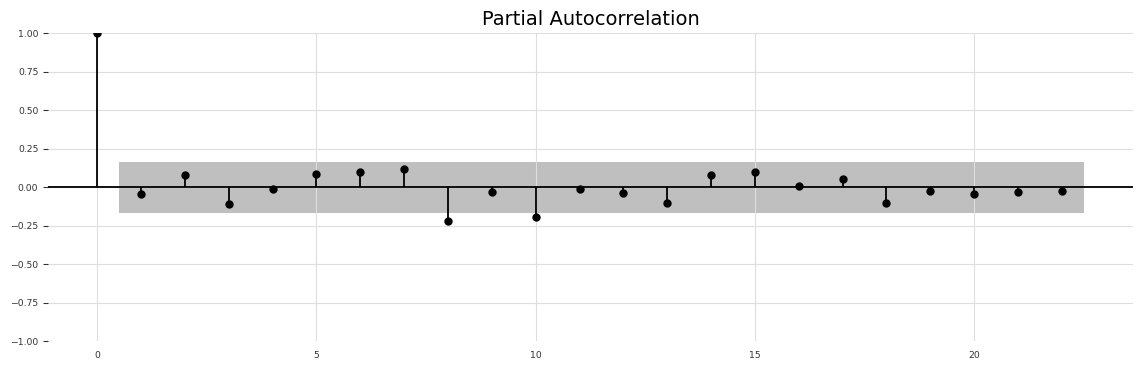

In [92]:
plot_acf(model.resid[1:])
plot_pacf(model.resid[1:]); plt.show()

<Axes: xlabel='month'>

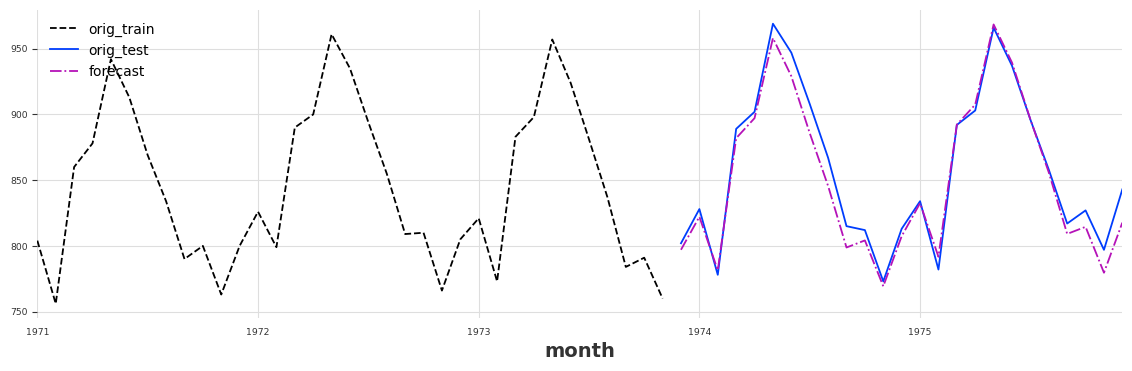

In [93]:
plot_forecast(model, '1971', milk_train, milk_test)
# plt.savefig('images/fig_10.24.png', bbox_inches='tight', dpi=300)

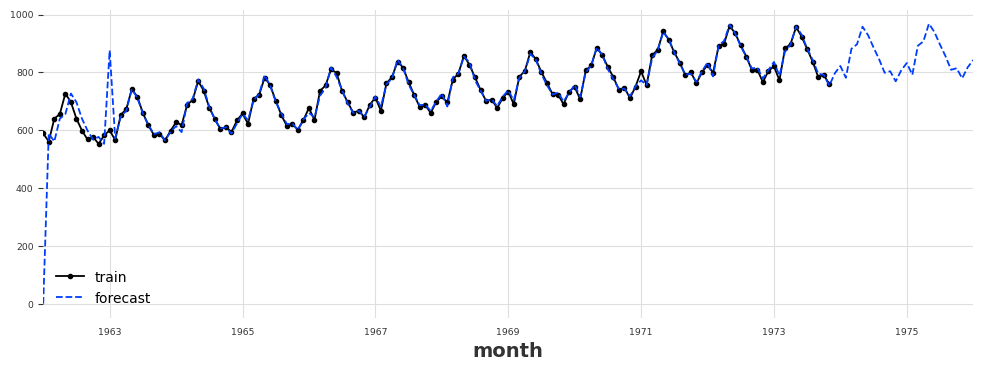

In [94]:
n = milk.shape[0]
milk_train.plot(style='.-', figsize=(12,4))
model.predict(end=n).plot(style='--')
plt.legend(['train', 'forecast'])

## There is more

In [95]:
%%time
P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(2))]*3

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')
    m = SARIMAX(milk_train,
                order=(p,d,q),
                seasonal_order=(P, D, Q, 12),
                enforce_stationarity=False)
    res = m.fit(disp=0)
    y = milk_test.values.ravel()
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic,
                'AICc': res.aicc,
                'BIC': res.bic,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

Running model #0 using SARIMA(0,0,0)(0,0,0,12)
Running model #15 using SARIMA(0,0,1)(1,1,1,12)
Running model #30 using SARIMA(0,1,0)(1,1,0,12)
Running model #45 using SARIMA(0,1,2)(1,0,1,12)
Running model #60 using SARIMA(0,2,1)(1,0,0,12)
Running model #75 using SARIMA(1,0,0)(0,1,1,12)
Running model #90 using SARIMA(1,0,2)(0,1,0,12)
Running model #105 using SARIMA(1,1,1)(0,0,1,12)
Running model #120 using SARIMA(1,2,0)(0,0,0,12)
Running model #135 using SARIMA(1,2,1)(1,1,1,12)
Running model #150 using SARIMA(2,0,0)(1,1,0,12)
Running model #165 using SARIMA(2,0,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,1)(1,0,0,12)
Running model #195 using SARIMA(2,2,0)(0,1,1,12)
Running model #210 using SARIMA(2,2,2)(0,1,0,12)
CPU times: user 1min 22s, sys: 1.82 s, total: 1min 24s
Wall time: 1min 31s


In [96]:
best_model = get_best_model(score, 'AIC')

Best model: 211 with lowest AIC score: 795.4217652246253


In [97]:
results = pd.DataFrame(score).T.sort_values(by='AIC').reset_index()
results.head(20)

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.17819,15.135855,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,67,"(0, 2, 2)","(0, 1, 1)",795.51592,795.882892,806.460713,0.32824,27.79722,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487077,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,191,"(2, 1, 2)","(1, 1, 1)",796.867371,797.9141,816.081896,0.112242,9.645432,0.00907,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.12826,10.998608,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.79808,0.289729,24.535571,0.02477,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
6,215,"(2, 2, 2)","(1, 1, 1)",797.41798,798.474583,816.571369,0.180097,15.295306,0.014636,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
7,115,"(1, 1, 2)","(0, 1, 1)",798.57341,799.123869,812.298071,0.1356,11.611922,0.010527,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,47,"(0, 1, 2)","(1, 1, 1)",798.638183,799.188642,812.362843,0.133006,11.396137,0.010312,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
9,71,"(0, 2, 2)","(1, 1, 1)",798.88124,799.436795,812.562232,0.427679,36.193943,0.036859,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [98]:
results = pd.DataFrame(score).T.sort_values(by='BIC').reset_index()
results.head(20)

,index,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
0,67,"(0, 2, 2)","(0, 1, 1)",795.51592,795.882892,806.460713,0.32824,27.79722,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
1,43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487077,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
2,35,"(0, 1, 1)","(0, 1, 1)",802.462674,802.676959,810.723444,0.13409,11.489677,0.01037,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
3,139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.79808,0.289729,24.535571,0.02477,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
4,211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.17819,15.135855,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
5,115,"(1, 1, 2)","(0, 1, 1)",798.57341,799.123869,812.298071,0.1356,11.611922,0.010527,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
6,47,"(0, 1, 2)","(1, 1, 1)",798.638183,799.188642,812.362843,0.133006,11.396137,0.010312,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
7,71,"(0, 2, 2)","(1, 1, 1)",798.88124,799.436795,812.562232,0.427679,36.193943,0.036859,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
8,187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.12826,10.998608,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
9,131,"(1, 2, 1)","(0, 1, 1)",802.770371,803.134007,813.750099,0.205805,17.449497,0.016938,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [ ]:
score[211]

{'non-seasonal order': (2, 2, 2),
 'seasonal order': (0, 1, 1),
 'AIC': 795.4217652843622,
 'AICc': 796.2068120133342,
 'BIC': 811.8389559747292,
 'RMSPE': 0.17818990207115598,
 'RMSE': 15.135861916002764,
 'MAPE': 0.014454262783870993,
 'model': <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x7fb7f22d9df0>}

<AxesSubplot:xlabel='month'>

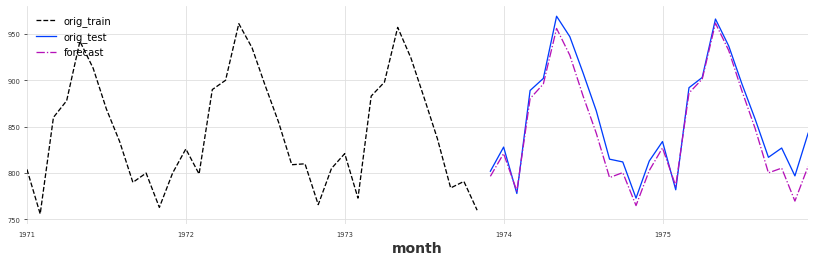

In [ ]:
plot_forecast(best_model, '1971', milk_train, milk_test)
# plt.savefig('images/fig_10.25.png', bbox_inches='tight', dpi=300)